In [1]:
! pip install -q kaggle

In [2]:
import json
token = {"username":"crownsss","key":"1a9398b0f5266dda733f318786e96b8d"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

# 首先下载kaggle数据集，大家可以搜一下具体的下载方式，这里我直接使用colab下载了

In [3]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d mirichoi0218/insurance #(数据下载API)
! unzip insurance.zip -d health-insurance

  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 9.37MB/s]
Archive:  insurance.zip
  inflating: health-insurance/insurance.csv  


--2022-08-17 07:11:36--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  43.4MB/s    in 0.2s    

2022-08-17 07:11:37 (43.4 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

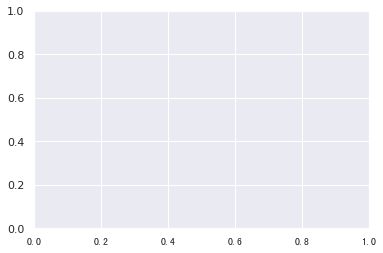

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set(font=zhfont.get_name())
plt.xticks(fontproperties=zhfont)

# 导入数据集

In [6]:
# 导入基本库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats  
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
import numpy as np
import pickle

import matplotlib.pyplot as plt 
 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号 #有中文出现的情况，需要u'内容'
      
sns.set_style({'font.sans-serif':['SimHei','Arial']})

# 读取数据，并总览一下数据情况。
health_ins_df = pd.read_csv("health-insurance/insurance.csv")
health_ins_df.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
# 查看列
health_ins_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [8]:
# 查看维度
health_ins_df.shape

(1338, 7)

In [9]:
# 查看基本信息
health_ins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
# 描述性统计
health_ins_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# 数据清洗和EDA

In [11]:
# 查看缺失值
health_ins_df.isnull().sum()
# 可以看出数据集中没有缺失值

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

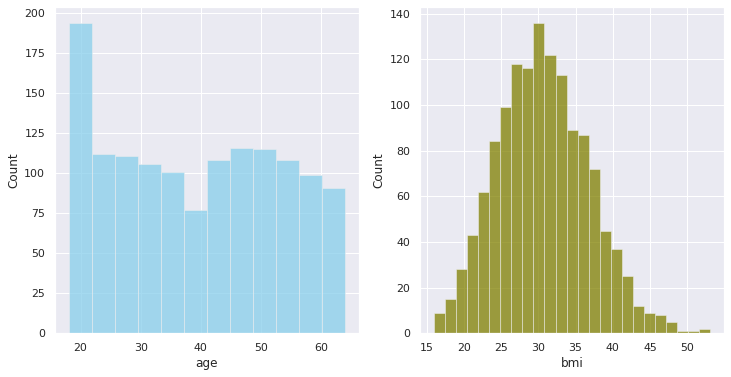

In [12]:
# 数值型变量的可视化
# 直方图绘制
fig,axes = plt.subplots(1,2,figsize=(12,6))
plt.style.use('ggplot')#使用ggplot主题，R语言的一个绘图包
sns.histplot( health_ins_df['age'] , color="skyblue",ax=axes[0])
sns.histplot( health_ins_df['bmi'] , color="olive",ax=axes[1])
plt.show()

- 我们可以年龄进行分组转换为年龄段
- BMI接近正态分布

In [13]:

outlier_list = boxplot_stats(health_ins_df.bmi).pop(0)['fliers'].tolist()
print(outlier_list)

#Finding the number of rows containing outliers
outlier_bmi_rows = health_ins_df[health_ins_df.bmi.isin(outlier_list)].shape[0]
print("Number of rows contaning outliers in bmi : ", outlier_bmi_rows)

#Percentage of rows which are outliers
percent_bmi_outlier = (outlier_bmi_rows/health_ins_df.shape[0])*100
print("Percentage of outliers in bmi columns : ", percent_bmi_outlier)

[49.06, 48.07, 47.52, 47.41, 50.38, 47.6, 52.58, 47.74, 53.13]
Number of rows contaning outliers in bmi :  9
Percentage of outliers in bmi columns :  0.672645739910314


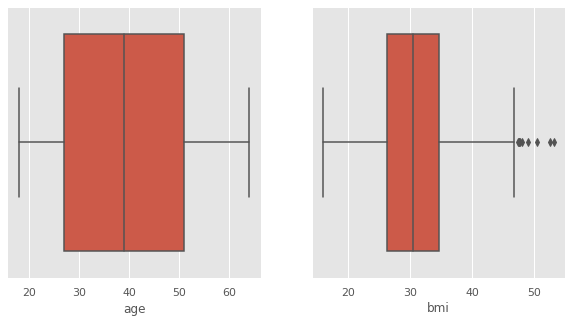

In [14]:
# 箱线图
fig,axes=plt.subplots(1,2,figsize=(10,5))

sns.boxplot(x = 'age', data = health_ins_df, ax=axes[0])
sns.boxplot(x = 'bmi', data = health_ins_df, ax=axes[1])

plt.show()

可以看出BMI存在一些离群值，现在我们来看一下这些点

In [15]:
outlier_list = boxplot_stats(health_ins_df.bmi).pop(0)['fliers'].tolist()
print(outlier_list)
#查找包含异常值的行数
outlier_bmi_rows = health_ins_df[health_ins_df.bmi.isin(outlier_list)].shape[0]
print("bmi 中包含异常值的行数：", outlier_bmi_rows)

#离群值占比
#Percentage of rows which are outliers
percent_bmi_outlier = (outlier_bmi_rows/health_ins_df.shape[0])*100
print("bmi离群值异常值的百分比 : ", percent_bmi_outlier)

[49.06, 48.07, 47.52, 47.41, 50.38, 47.6, 52.58, 47.74, 53.13]
bmi 中包含异常值的行数： 9
bmi离群值异常值的百分比 :  0.672645739910314


# 数值变量的数据转换

In [16]:
# 将年龄转换为分桶的
print("Minimum value for age : ", health_ins_df['age'].min(),"\nMaximum value for age : ", health_ins_df['age'].max())

#18至40岁的年龄将属于青年
#41至58岁的年龄将低于中年
#58岁以上将落入老年

health_ins_df.loc[(health_ins_df['age'] >=18) & (health_ins_df['age'] <= 40), 'age_group'] = 'young'
health_ins_df.loc[(health_ins_df['age'] >= 41) & (health_ins_df['age'] <= 58), 'age_group'] = 'mid'
health_ins_df.loc[health_ins_df['age'] > 58, 'age_group'] = 'old'

Minimum value for age :  18 
Maximum value for age :  64


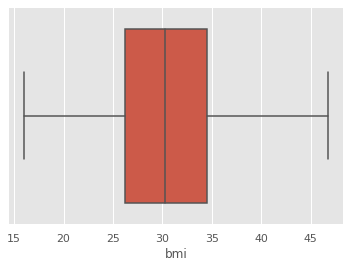

In [17]:
# 去除BMI中的异常值
health_ins_df_clean = health_ins_df[~health_ins_df.bmi.isin(outlier_list)]
sns.boxplot(x = 'bmi', data = health_ins_df_clean)

# 分类型变量的可视化分析 

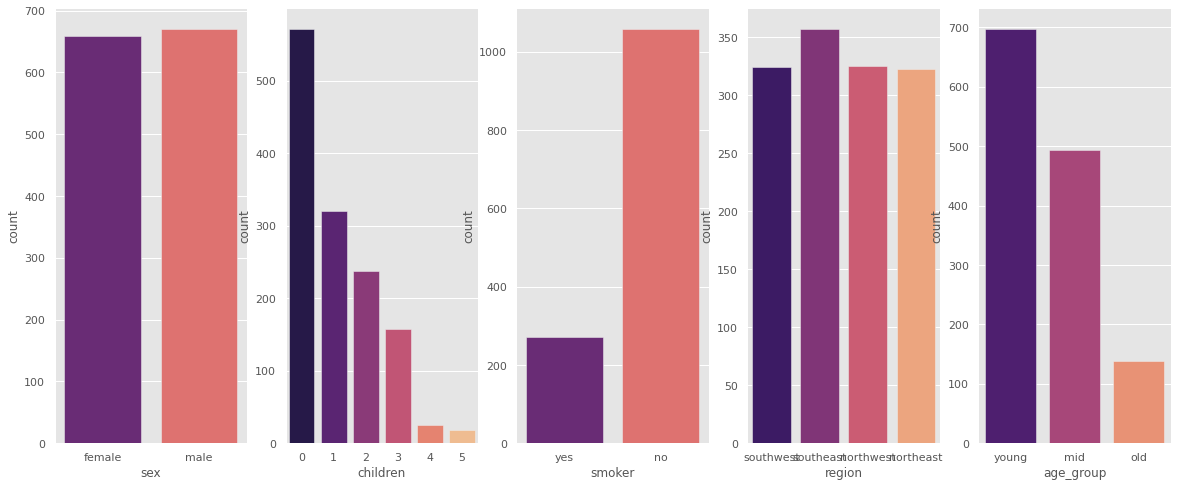

In [18]:
fig,axes=plt.subplots(1,5,figsize=(20,8))
sns.countplot(x = 'sex', data = health_ins_df_clean, palette = 'magma',ax=axes[0])
sns.countplot(x = 'children', data = health_ins_df_clean, palette = 'magma',ax=axes[1])
sns.countplot(x = 'smoker', data = health_ins_df_clean, palette = 'magma',ax=axes[2])
sns.countplot(x = 'region', data = health_ins_df_clean, palette = 'magma',ax=axes[3])
sns.countplot(x = 'age_group', data = health_ins_df_clean, palette = 'magma',ax=axes[4])

相关性分析

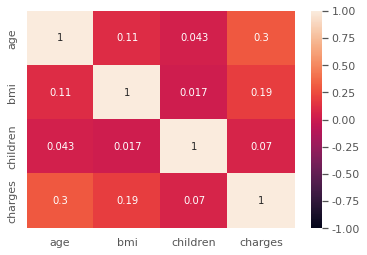

In [19]:
heatmap = sns.heatmap(health_ins_df_clean.corr(), vmin=-1, vmax=1, annot=True)

年龄和BMI与费用相关性较强

多元分析

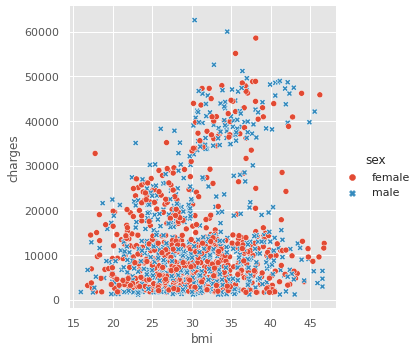

In [20]:
sns.relplot(x="bmi", y="charges",hue="sex", style = "sex", data=health_ins_df_clean);

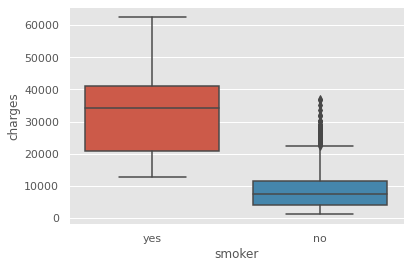

In [21]:

sns.boxplot(x="smoker", y="charges", data=health_ins_df_clean)

从上图可以看出，吸烟与不吸烟的费用有明显的差异。不同性别对bmi与charge之间的关系没有明显的差异

In [22]:
#NUMBER类别中的类别变量
categorical_var = ['sex','children','smoker','region','age_group']
for cat_value in categorical_var:
  print(cat_value," - ",health_ins_df_clean[cat_value].unique())

sex  -  ['female' 'male']
children  -  [0 1 3 2 5 4]
smoker  -  ['yes' 'no']
region  -  ['southwest' 'southeast' 'northwest' 'northeast']
age_group  -  ['young' 'mid' 'old']


In [23]:
# 将分类型变量转换为one-hot编码
health_ins_df_processed = pd.get_dummies(health_ins_df_clean, columns=['sex','children','smoker','region','age_group'], prefix=['sex','children','smoker','region','age_group'])
health_ins_df_processed.drop(['age'],axis = 1,inplace=True)

In [24]:
health_ins_df_processed.head(5)

,bmi,charges,sex_female,sex_male,children_0,children_1,children_2,children_3,children_4,children_5,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_mid,age_group_old,age_group_young
0,27.900,16884.92400,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,33.770,1725.55230,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2,33.000,4449.46200,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,22.705,21984.47061,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
4,28.880,3866.85520,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1


# 构建一个基础模型

In [25]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
X = health_ins_df_processed.loc[:, health_ins_df_processed.columns != 'charges']
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


lm.fit(X_train,y_train)
print("R-Squared on train dataset={}".format(lm.score(X_train,y_train)))

lm.fit(X_test,y_test)   
print("R-Squaredon test dataset={}".format(lm.score(X_test,y_test)))

R-Squared on train dataset=0.7494776882061486
R-Squaredon test dataset=0.7372938495110573


# 构建一个决策树回归模型

In [26]:
X = health_ins_df_processed.loc[:, health_ins_df_processed.columns != 'charges']
y = health_ins_df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

dtr = DecisionTreeRegressor(max_depth=4,min_samples_split=5,max_leaf_nodes=10)

dtr.fit(X_train,y_train)
print("R-Squared on train dataset={}".format(dtr.score(X_train,y_train)))

dtr.fit(X_test,y_test)   
print("R-Squaredon test dataset={}".format(dtr.score(X_test,y_test)))

R-Squared on train dataset=0.8594291626976573
R-Squaredon test dataset=0.8571718114547656


In [27]:
# 使用网格搜索进行超参数调整
param_grid = {
"min_samples_split": [2, 5, 10, 15,20, 40],
"max_depth": [2, 4, 6, 8],
"max_leaf_nodes": [2, 5, 10, 20, 100],
"min_samples_leaf": [2, 5, 10, 20, 100],
}

grid_cv_dtr = GridSearchCV(dtr, param_grid, cv=5)

grid_cv_dtr.fit(X,y)

print("R-Squared::{}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtr.best_params_))

#R-Squared::0.8464037958681339
#Best Hyperparameters::
#{'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}

R-Squared::0.8464037958681339
Best Hyperparameters::
{'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}


# 构建一个Gradient Boosting回归模型
梯度提升回归模型的主要调整参数
- learning_rate:学习率，默认为0.1
- n_estimators:默认为100
- max_depth:单个回归估计器的最大深度。最大深度限制了树中的节点数。调整此参数以获得最佳性能；最佳值取决于输入变量的相互作用。值必须在 [1, inf) 范围内。
- min_samples_split:拆分内部节点所需的最小样本数：
- min_samples_leaf:叶节点最小样本数，这个参数会影响模型的平滑效果，尤其是在回归中。

下面使用gridsearch来分别对这些参数调整。考虑到运行速度，这里进行了两步来调参。


In [28]:
X = health_ins_df_processed.loc[:, health_ins_df_processed.columns != 'charges']
y = health_ins_df_processed['charges']
# 数据集拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
# 第一轮超参数设置
p_tuning_1 = {'learning_rate':[0.020,0.015,0.01], 'n_estimators':[250,500,750]}
# 第一轮使用网格搜索
tuning_1 = GridSearchCV(estimator =ensemble.GradientBoostingRegressor(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,loss = 'ls'),
                        param_grid = p_tuning_1, n_jobs=4,cv=5,verbose = True)
tuning_1.fit(X_train,y_train)
tuning_1.cv_results_, tuning_1.best_score_, tuning_1.best_params_

#0.8543951767533278,
#{'learning_rate': 0.015, 'n_estimators': 250}

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


({'mean_fit_time': array([0.93033953, 2.17604942, 2.40582275, 0.75398693, 1.88998609,
         3.04191098, 1.00034266, 2.64972916, 3.7665452 ]),
  'std_fit_time': array([0.02198099, 0.14956736, 0.1401863 , 0.01044098, 0.11360786,
         0.22889888, 0.11380432, 0.05127283, 0.56390293]),
  'mean_score_time': array([0.01764259, 0.02601213, 0.0182991 , 0.01312881, 0.02345424,
         0.02766876, 0.01379819, 0.02135038, 0.02560244]),
  'std_score_time': array([0.00768666, 0.01011614, 0.00307461, 0.00068747, 0.00922022,
         0.00899281, 0.0043838 , 0.00466125, 0.01048999]),
  'param_learning_rate': masked_array(data=[0.02, 0.02, 0.02, 0.015, 0.015, 0.015, 0.01, 0.01,
                     0.01],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[250, 500, 750, 250, 500, 750, 250, 500, 750],
               mask=[False, False, False, Fals

In [29]:
# 第二次调参
p_tuning_2 = {'max_depth':[2,4,6,8], 'min_samples_split':[2,5,8,10],'min_samples_leaf':[1,2,5]}

tuning_2 = GridSearchCV(estimator =ensemble.GradientBoostingRegressor(learning_rate=0.015, n_estimators=250, subsample=1,loss = 'ls'), 
            param_grid = p_tuning_2, n_jobs=4,cv=5,verbose = True)#这里使用了第一次调参的结果
tuning_2.fit(X_train,y_train)
tuning_2.cv_results_, tuning_2.best_score_, tuning_2.best_params_

# 0.8614639096054806,
# {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2})

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


({'mean_fit_time': array([0.63631959, 0.62680583, 0.52735548, 0.50522704, 0.49523897,
         0.50640383, 0.51098285, 0.49042706, 0.51463251, 0.50141368,
         0.4953177 , 0.49713025, 0.72156553, 0.71434522, 0.7315094 ,
         0.71747985, 0.72309833, 0.72742319, 0.76942863, 0.71605034,
         0.73797874, 0.78718066, 0.72743568, 0.72464108, 0.99180121,
         0.97025576, 0.95901732, 1.23043509, 1.77729821, 1.06093988,
         0.95965571, 0.94590869, 0.91955638, 0.93192229, 0.93346577,
         0.93660111, 1.28959103, 1.20589719, 1.17868004, 1.26609449,
         1.20441046, 1.4600512 , 1.36594844, 1.12692838, 1.10502806,
         1.08713503, 1.09216666, 1.05332561]),
  'std_fit_time': array([0.02031276, 0.02917624, 0.05483483, 0.01172972, 0.00405064,
         0.00844451, 0.01064526, 0.00632402, 0.01705367, 0.01788173,
         0.01050163, 0.0163158 , 0.01104153, 0.01054067, 0.01874623,
         0.0135183 , 0.00597545, 0.01370893, 0.10151672, 0.04706963,
         0.02745759, 0.

经过上述调参结果后，我们得到了最终模型如下：
- {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2})
- {'learning_rate': 0.015, 'n_estimators': 250})

In [30]:
#最终的模型
f_model = ensemble.GradientBoostingRegressor(learning_rate=0.015,n_estimators=250,max_depth=2,min_samples_leaf=5,
                                             min_samples_split=2,subsample=1,loss = 'squared_error')
f_model.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(f_model.score(X_train, y_train)))

f_model.fit(X_test, y_test)
print("Accuracy score (test): {0:.3f}".format(f_model.score(X_test, y_test)))

Accuracy score (training): 0.866
Accuracy score (test): 0.818


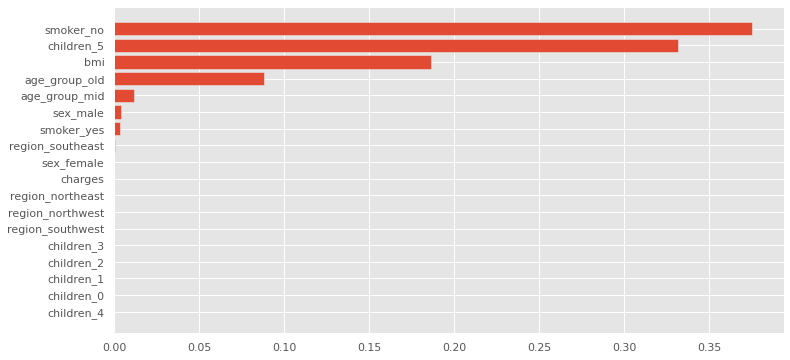

In [31]:
#查看变量的重要性
feature_importance = f_model.feature_importances_
sorted_idx = np.argsort(feature_importance)#得到重要性的排序索引
fig = plt.figure(figsize=(12, 6))
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(health_ins_df_processed.columns)[sorted_idx])
plt.show()

# 保存模型

In [32]:
# 保存模型
filename = 'health_insurance_data_model.sav'
pickle.dump(f_model, open(filename, 'wb'))

In [33]:
# 加载模型
filename = 'health_insurance_data_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result) #测试集精度

0.8180114370687565
